In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, check_datetime_sanity, check_singularity_of_values
from utils.plotting import *
from src.src import *

In [4]:
# load data
df_all = load_data(file_name="merged_data.csv", file_path=OUT_DATA_DIR)
data_dict = load_data(file_name="merged_data_dict.pkl", file_path=OUT_DATA_DIR)

df_w = df_all.copy()

In [5]:
# Load data
predicted = "sp_close_lead1"

year_start = 2012
year_end = 2021
year_spread = f'years{year_end}_{year_start}'
interval = 'daily'

# training on X years
df_w = df_w[(df_w["date"] >= dt.datetime(year=year_start, month=1, day=1).date())
            &(df_w["date"] <= dt.datetime(year=year_end, month=12, day=31).date())]
print(f'data compromises {year_end - year_start + 1} years: {df_w.shape[0]} lines')

data compromises 10 years: 2516 lines


In [ ]:
data_dict["model_features"].update(predicted=predicted)
data_dict["model_metrics"].update(year_spread=year_spread)

# Select data

In [7]:
## SELECT COLS INCLUDED HERE
# # len daily returns
drop_cols = data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"] + data_dict["data"]["df_cols"]["naaim_risk"] + data_dict["data"]["df_cols"]["aaii_bull"] #+ data_dict["data"]["df_cols"]["cbeo_vix"] + data_dict["data"]["df_cols"]["termspread"]

# # len 1500
# drop_cols = data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"] + data_dict["data"]["df_cols"]["naaim_risk"]

# # len 760
# drop_cols = data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"] + data_dict["data"]["df_cols"]["put_call"]

# # len 660
# drop_cols = data_dict["data"]["df_cols"]["fears"] + data_dict["data"]["df_cols"]["goog_sent"]

# # len 440
# drop_cols = data_dict["data"]["df_cols"]["fears"]

# # len 270
# drop_cols = None

## DROP COLS
if drop_cols != None:
    df_w = df_w.drop(drop_cols, axis=1).copy()

In [8]:
# keep actual sp500 prices
data_dict["data"].update(sp_true_vals="sp_true_vals")

## preserve actual prices
df_w[data_dict["data"]["sp_true_vals"]] = df_w["sp_close"]

In [9]:
print(df_w.shape)

(2516, 26)


In [10]:
# all sp cols, lags & leads
data_dict["data"].update(sp_cols=[item for item in df_w.columns if "sp_close" in item])

relevant_cols=[
    'vixo',
    'ff_M_RF',
    'ff_SMB',
    'ff_HML',
    'ff_RMW',
    'ff_CMA',
    'termspread',
    'macd',
    'macdh',
    'williamsr'
] 

# relevant cols are features + sp_cols + target col, thus all relevant columns
relevant_cols = relevant_cols + data_dict["data"]["sp_cols"]

data_dict["data"].update(relevant_cols=relevant_cols)

In [11]:
# sanity check
_ = [item for item in data_dict["data"]["relevant_cols"] if item not in df_w.columns]
assert len(_) == 0, f"Relevant cols has columns not pertaining to df: {_}"
# datetime sanity
check_datetime_sanity(df_w.date)
check_singularity_of_values(df_w.date)

In [14]:
_

2516

In [13]:
_ = len(df_w)
df_w.dropna(inplace=True)
print(f'dropped rows: {_ - len(df_w)}')

dropped rows: 122


# Transform

In [14]:
# ff factor np.log(1 + x)
log_trans = ["vixo", 'aaii_Bullish', 'aaii_Bearish', 'aaii_Neutral']
log_returns = ['termspread'] + data_dict["data"]["sp_cols"]
ff_to_log = [item for item in data_dict['data']['df_cols']['ff_factors5'] if item in df_w.columns]

log_trans = [item for item in log_trans if item in df_w.columns]
log_returns = [item for item in log_returns if item in df_w.columns]

In [15]:
df_w, t_dist, t_log = df_transform(df_w,
                                   cols=log_trans,
                                   func=arr_log_transform)

df_w, r_dist, r_log = df_transform(df_w,
                                   cols=log_returns,
                                   func=arr_log_return)

df_w, t_dist, ff_log = df_transform(df_w,
                                   cols=ff_to_log,
                                   func=arr_ff_to_log)

In [17]:
t_dist.update(r_dist)

data_dict["data_transformation"].update(dist_translation=t_dist)
data_dict["data_transformation"].update(log_transformation=t_log)
data_dict["data_transformation"].update(log_returns=r_log)
data_dict["data_transformation"].update(ff_to_log=ff_log)

print(data_dict["data_transformation"]["log_transformation"])
print(data_dict['data_transformation']['log_returns'])
print(data_dict['data_transformation']['ff_to_log'])

{'vixo': True}
{'termspread': True, 'sp_close': True}
{'ff_M_RF': True, 'ff_SMB': True, 'ff_HML': True, 'ff_RMW': True, 'ff_CMA': True, 'ff_RF': True}


In [18]:
data_dict["data_transformation"]['dist_translation']

{'ff_M_RF': None,
 'ff_SMB': None,
 'ff_HML': None,
 'ff_RMW': None,
 'ff_CMA': None,
 'ff_RF': None,
 'termspread': False,
 'sp_close': False}

# Outlier test

In [21]:
for col in data_dict['data']['relevant_cols']:
    df_w[f'{col}_is_outlier'] = is_outlier(df_w[col])

In [25]:
# outliers based on 3iqr from mean, outliers are not excluded
df_w[[item for item in df_w.columns if 'is_outlier' in item]].sum()

vixo_is_outlier          19
ff_M_RF_is_outlier       56
ff_SMB_is_outlier        19
ff_HML_is_outlier        73
ff_RMW_is_outlier        25
ff_CMA_is_outlier        25
termspread_is_outlier    37
macd_is_outlier          47
macdh_is_outlier         79
williamsr_is_outlier      0
sp_close_is_outlier      62
dtype: int64

# Stats Test

In [26]:
# test normality & stationarity
# siginficance at 5%
stest = StatsTest(plot=True, print_results=True)

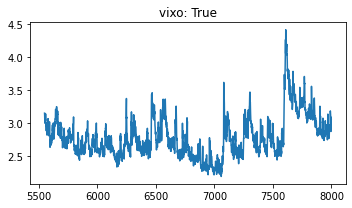

Stationarity Test Results
P-Values: 3.944274434188737e-05
Test-stats: -4.872470195727979
Time series is stationary: True
Number of lags used: 6


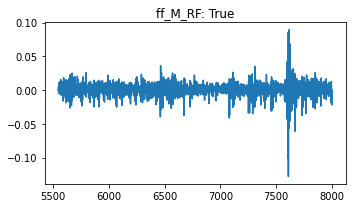

Stationarity Test Results
P-Values: 2.880609288178858e-25
Test-stats: -13.508770074303609
Time series is stationary: True
Number of lags used: 12


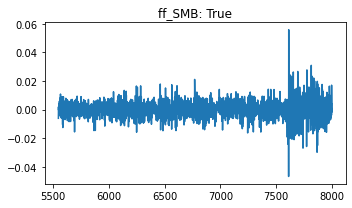

Stationarity Test Results
P-Values: 0.0
Test-stats: -49.95547520052508
Time series is stationary: True
Number of lags used: 0


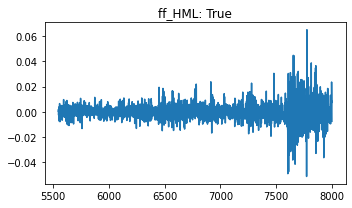

Stationarity Test Results
P-Values: 0.0
Test-stats: -29.538128130773234
Time series is stationary: True
Number of lags used: 2


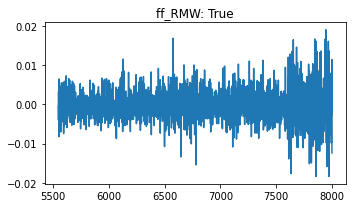

Stationarity Test Results
P-Values: 3.237033372886969e-15
Test-stats: -9.119337332605358
Time series is stationary: True
Number of lags used: 27


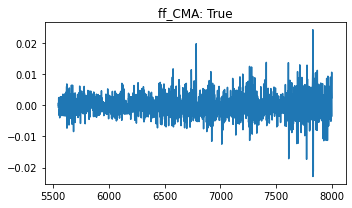

Stationarity Test Results
P-Values: 0.0
Test-stats: -26.220717881513917
Time series is stationary: True
Number of lags used: 3


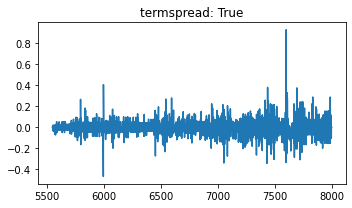

Stationarity Test Results
P-Values: 5.659380600615941e-17
Test-stats: -9.810943386870955
Time series is stationary: True
Number of lags used: 26


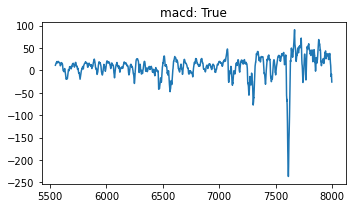

Stationarity Test Results
P-Values: 1.1150156362658471e-10
Test-stats: -7.33301790728089
Time series is stationary: True
Number of lags used: 26


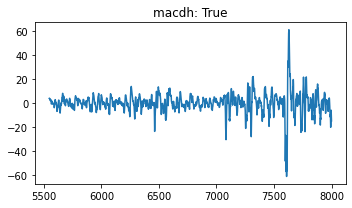

Stationarity Test Results
P-Values: 2.780486360684386e-22
Test-stats: -12.037553767978528
Time series is stationary: True
Number of lags used: 15


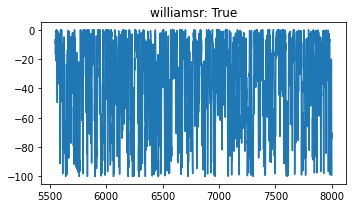

Stationarity Test Results
P-Values: 5.659947960111473e-29
Test-stats: -16.05944565174324
Time series is stationary: True
Number of lags used: 3


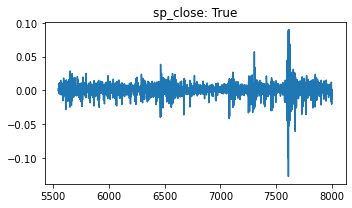

Stationarity Test Results
P-Values: 1.3895955195356576e-25
Test-stats: -13.682922888219426
Time series is stationary: True
Number of lags used: 12


{'vixo': True,
 'ff_M_RF': True,
 'ff_SMB': True,
 'ff_HML': True,
 'ff_RMW': True,
 'ff_CMA': True,
 'termspread': True,
 'macd': True,
 'macdh': True,
 'williamsr': True,
 'sp_close': True}

In [27]:
# test data for stationarity
stationarity = stest.df_test_stationarity(df_w, [item for item in data_dict["data"]["relevant_cols"]])
data_dict["data_stests"].update(stationarity=stationarity)
stationarity

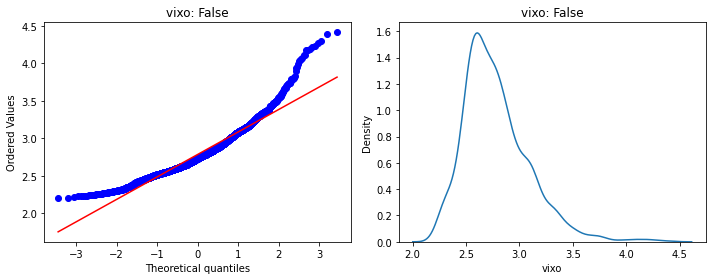

Normality Test Results
P-Values: 1.8335162327476813e-113
Test-stats: 519.1717598928319
Series is normally distributed: False


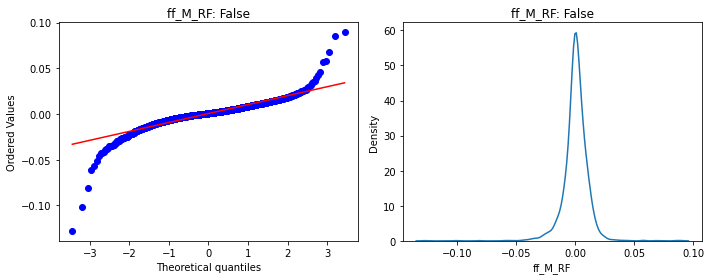

Normality Test Results
P-Values: 1.427101618414652e-206
Test-stats: 947.953767219183
Series is normally distributed: False


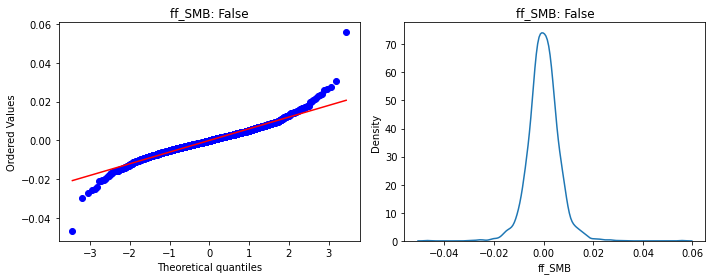

Normality Test Results
P-Values: 2.0961452118119338e-70
Test-stats: 320.8817129301591
Series is normally distributed: False


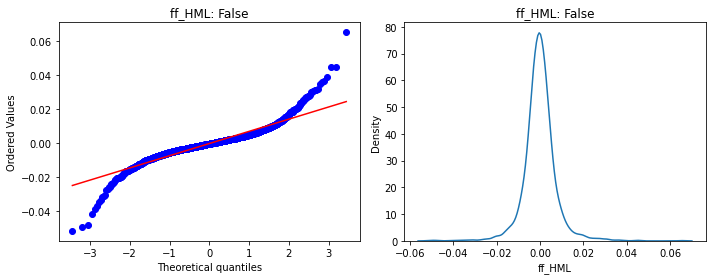

Normality Test Results
P-Values: 4.0781453772783284e-93
Test-stats: 425.46954265553694
Series is normally distributed: False


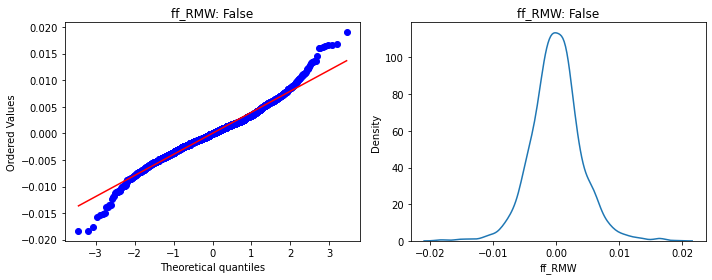

Normality Test Results
P-Values: 2.365032812712709e-27
Test-stats: 122.61801122938891
Series is normally distributed: False


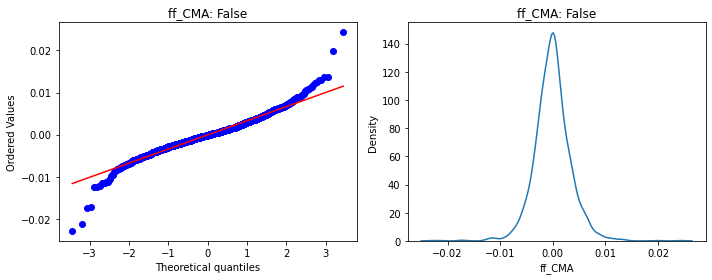

Normality Test Results
P-Values: 6.2339436788465424e-52
Test-stats: 235.8088313777979
Series is normally distributed: False


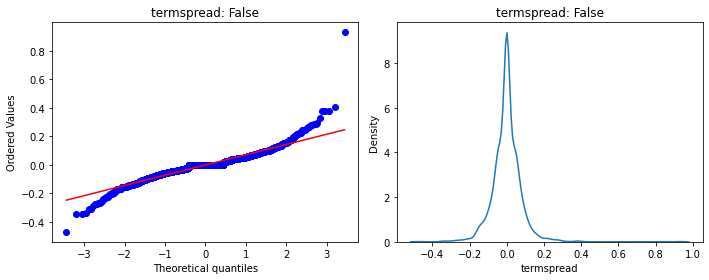

Normality Test Results
P-Values: 2.2735414787325462e-153
Test-stats: 702.9483609790666
Series is normally distributed: False


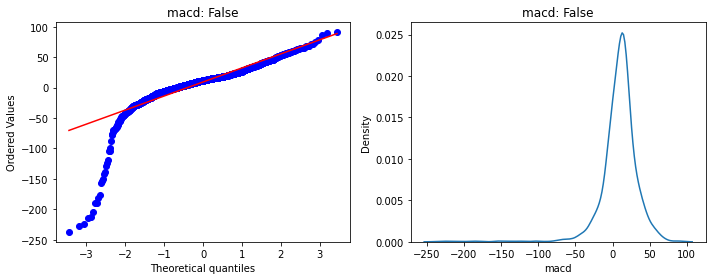

Normality Test Results
P-Values: 0.0
Test-stats: 1776.4373847384288
Series is normally distributed: False


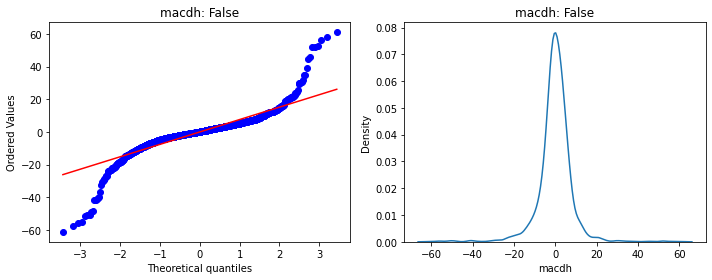

Normality Test Results
P-Values: 1.0018136568813068e-124
Test-stats: 571.0374790341402
Series is normally distributed: False


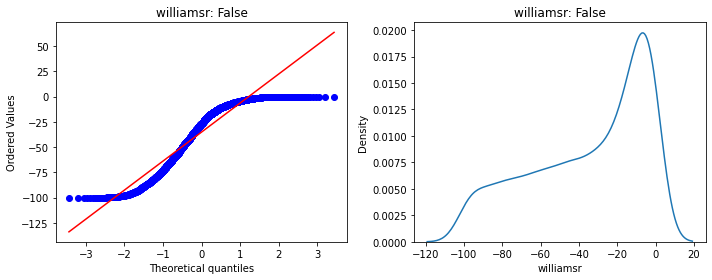

Normality Test Results
P-Values: 5.419655228375471e-98
Test-stats: 447.92661382197804
Series is normally distributed: False


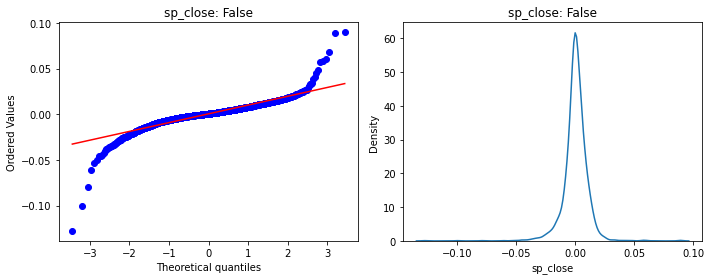

Normality Test Results
P-Values: 1.3626179983362696e-196
Test-stats: 901.9945407574883
Series is normally distributed: False


{'vixo': False,
 'ff_M_RF': False,
 'ff_SMB': False,
 'ff_HML': False,
 'ff_RMW': False,
 'ff_CMA': False,
 'termspread': False,
 'macd': False,
 'macdh': False,
 'williamsr': False,
 'sp_close': False}

In [28]:
# test data for normality
normality = stest.df_test_normality(df_w, cols=data_dict["data"]["relevant_cols"])
data_dict["data_stests"].update(normality=normality)
normality

In [26]:
# test sp_close for zero_mean
stest.arr_ttest_1samp(df_w.sp_close, 0)

TTest one sample for mean: 0
Test statistics: 5.345901199988091
Test pvalue: 9.947177032891474e-08
Population mean is equal to 0: True


True

# Lags

In [27]:
from statsmodels.tsa.stattools import adfuller

In [28]:
df_w, _ = shift_var_relative_to_df(df_w, "sp_close", no_lags=[-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

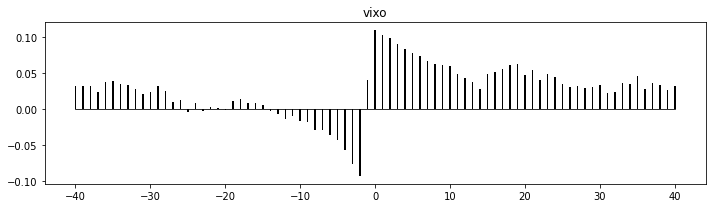

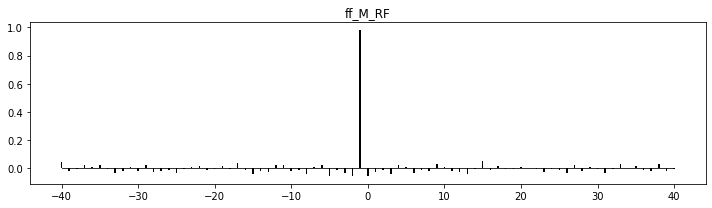

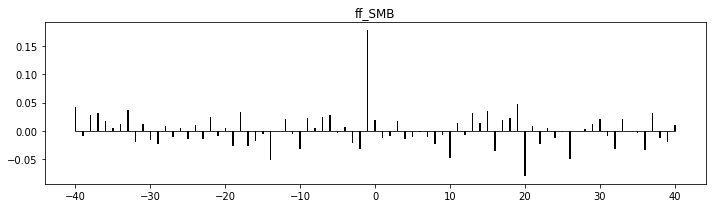

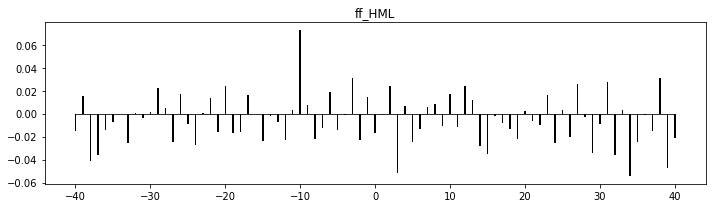

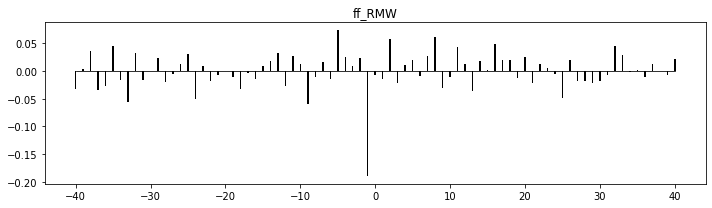

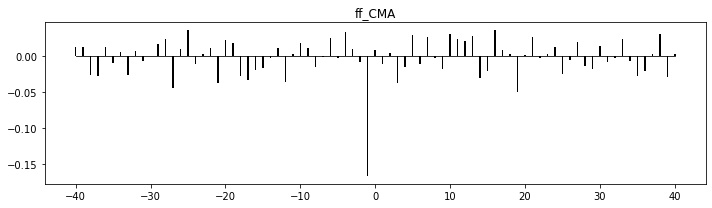

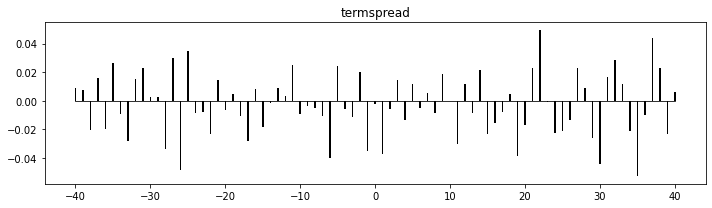

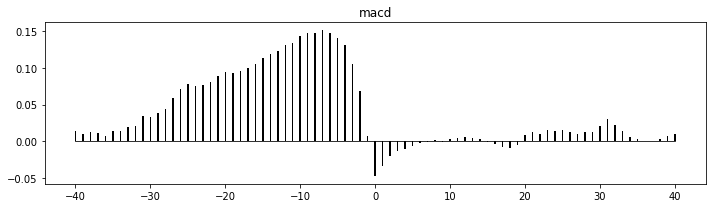

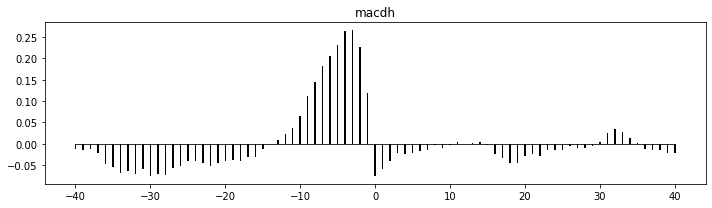

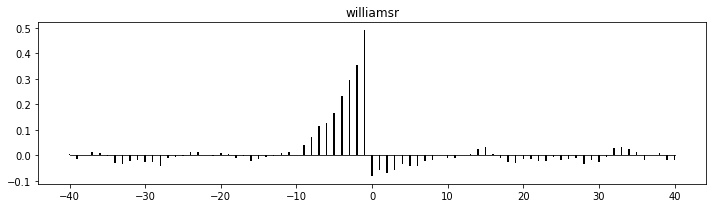

In [29]:
df_cross_corr(df_w,
              [item for item in data_dict["data"]["relevant_cols"] if item not in data_dict["data"]["sp_cols"]],
              predicted,
              show_plot=True,
              no_lags=40,
              figsize=(10, 3));

In [30]:
# df_w, _ = shift_var_relative_to_df(df_w, "termspread", no_lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
df_w, _ = shift_var_relative_to_df(df_w, "ff_M_RF", no_lags=[1, 2, 3, 4, 5, 6, 7, 8, 9])
# df_w, _ = shift_var_relative_to_df(df_w, "vixo", no_lags=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
df_w.dropna(inplace=True)

In [31]:
data_dict["data"].update(sp_cols=[item for item in df_w.columns if "sp_close" in item])

_ = list(set(data_dict['data']['relevant_cols'] + [item for item in list(df_w.columns) if "ff" in item] + 
             [item for item in list(df_w.columns) if "term" in item] + 
             [item for item in list(df_w.columns) if "vixo" in item]))
_.sort()
data_dict['data']['relevant_cols'] = _

In [32]:
data_dict['data']['relevant_cols'] 

['ff_CMA',
 'ff_HML',
 'ff_M_RF',
 'ff_M_RF_lag1',
 'ff_M_RF_lag2',
 'ff_M_RF_lag3',
 'ff_M_RF_lag4',
 'ff_M_RF_lag5',
 'ff_M_RF_lag6',
 'ff_M_RF_lag7',
 'ff_M_RF_lag8',
 'ff_M_RF_lag9',
 'ff_RF',
 'ff_RMW',
 'ff_SMB',
 'macd',
 'macdh',
 'sp_close',
 'termspread',
 'vixo',
 'williamsr']

# Feature Eng

In [33]:
df_w["weekday"] = is_day(df_w.date)

In [34]:
df_w = pd.concat([df_w,
                  pd.get_dummies(df_w.weekday).add_prefix("weekday_")],
                 axis=1)

# Saving

In [35]:
if sum([True for item in ['vixo', 'termspread', 'ff_M_RF', 'ff_SMB', 'ff_HML', 'ff_RMW', 'ff_CMA', 'ff_RF'] if item in df_w.columns]) == 8:
    name = f'{interval}_FF_TS_VX_{year_spread}'
    print(f'saving as name: {name}')
    save_file(df_w, file_name=f'df_{name}.csv', file_path=OUT_DATA_DIR, index=False)
    save_file(data_dict, file_name=f'dict_{name}.pkl', file_path=OUT_DATA_DIR)
    True

elif sum([True for item in ['ff_M_RF', 'ff_SMB', 'ff_HML', 'ff_RMW', 'ff_CMA', 'ff_RF'] if item in df_w.columns]) == 6:
    name = f'{interval}_FF_{year_spread}'
    print(f'saving as name: {name}')
    save_file(df_w, file_name=f'df_{name}.csv', file_path=OUT_DATA_DIR, index=False)
    save_file(data_dict, file_name=f'dict_{name}.pkl', file_path=OUT_DATA_DIR)



saving as name: daily_FF_TS_VX_years2021_2012
